# 6章 GLMの応用範囲を広げる

from データ解析のための統計モデリング入門: 一般化線形モデル・階層ベイズモデル・MCMC  
http://hosho.ees.hokudai.ac.jp/~kubo/ce/IwanamiBook.html


## 6.3 二項分布で表現する「あり・なし」のカウントデータ

In [31]:
import scipy.misc

In [32]:
def calc_binomial(N, q):
    ret = []
    for y in range(N+1):
        comb = scipy.misc.comb(N, y)
        ret.append(comb * (q**y)*((1-q)**(N-y)))
    return ret

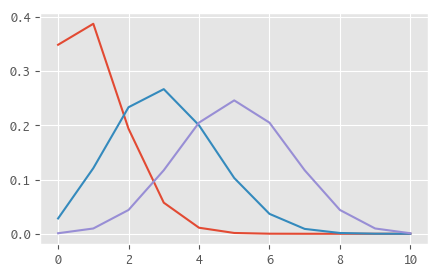

In [144]:
# 二項分布のプロット
fig = plt.figure(figsize=(5, 3))
plt.plot(calc_binomial(10, 0.1))
plt.plot(calc_binomial(10, 0.3))
plt.plot(calc_binomial(10, 0.5))

## 6.4 ロジスティック回帰とロジットリンク関数

In [27]:
def logistic(z):
    return 1/(1 + np.exp(-1 * z))
logistic = np.vectorize(logistic)

ロジスティック関数

$q_i = logistic(z_i) = \frac{1}{1 + exp(-z_i)}$

変形すると

$log\frac{q_i}{1 - q_i} = z_i$

この左辺をロジット関数 $logit(q_i)$と言う

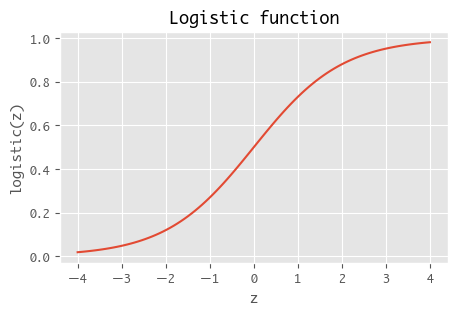

In [38]:
fig = plt.figure(figsize=(5, 3))
X = np.linspace(-4, 4, 100)
plt.plot(X, logistic(X))
plt.xlabel('z')
plt.ylabel('logistic(z)')
plt.title('Logistic function')

In [50]:
df = pd.read_csv('./data4a.csv')
df.head()

,N,y,x,f
0,8,1,9.76,C
1,8,6,10.48,C
2,8,5,10.83,C
3,8,6,10.94,C
4,8,1,9.37,C


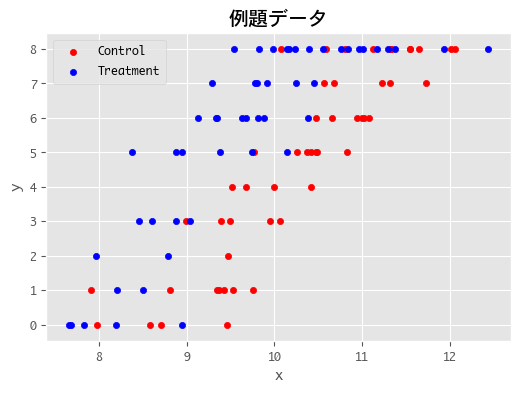

In [141]:
ax = df[df['f'] == 'C'][['x', 'y']].plot(kind='scatter', x='x', y='y', color='r', label='Control')
df[df['f'] == 'T'][['x', 'y']].plot(kind='scatter', x='x', y='y', color='b', ax=ax, label='Treatment')
plt.title('例題データ')

In [71]:
import statsmodels.api as sm
sm.version.full_version

'0.8.0'

In [96]:
df[df['f'] == 'C'].head()

,N,y,x,f
0,8,1,9.76,C
1,8,6,10.48,C
2,8,5,10.83,C
3,8,6,10.94,C
4,8,1,9.37,C


In [134]:
_df = df.copy()
_df['fT'] = np.where(_df['f'] == 'C', 0, 1)
_df['intercept'] = 1
_df['N-y'] = _df['N'] - _df['y']
binomial_model = sm.GLM(_df[['y', 'N-y']], _df[['x', 'fT', 'intercept']], family=sm.families.Binomial())
control_result = binomial_model.fit()

In [135]:
control_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           ['y', 'N-y']   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -133.11
Date:                Sun, 11 Feb 2018   Deviance:                       123.03
Time:                        18:16:00   Pearson chi2:                     13.7
No. Iterations:                     6                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x              1.9524      0.139     14.059      0.000       1.680       2.225
fT             2.0215      0.231      8.740      0.000       1.568       2.475
intercept    -19.5361      1.414    -13.818      0.000     -22.307     -16.765
==============================================================================
"""

- coef
  - 係数
- std err
  - 係数の標準偏差
- P>|z|
  - P-value、係数がゼロである場合の確率
- [0.025, 0.975]
  - 係数の信頼区間

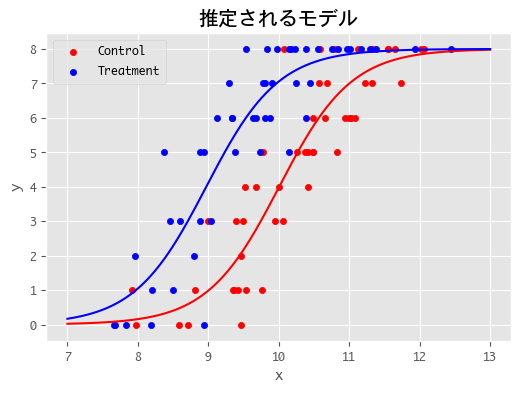

In [143]:
#データのプロット
ax = df[df['f'] == 'C'][['x', 'y']].plot(kind='scatter', x='x', y='y', color='r', label='Control')
df[df['f'] == 'T'][['x', 'y']].plot(kind='scatter', x='x', y='y', color='b', ax=ax, label='Treatment')
X = np.linspace(7, 13, 500)
# Control群の推定結果
yc = logistic(-19.5361 + X*1.9524)*8
ax.plot(X, yc, color='r')
# Treatment群の推定結果
yt = logistic(-19.5361 + X*1.9524 + 2.0215)*8
ax.plot(X, yt, color='b')
plt.title('推定されるモデル')

## 6.4.1 ロジットリンク関数の解釈

$\displaystyle
\begin{align*}
\frac{q_i}{1 - q_i}
&=
exp(線形予測子) \\
&=
exp(\beta_1 + \beta_{2}x_{i} + \beta_{3}f_i) \\
&=
exp(\beta_1)exp(\beta_{2}x_{i})exp(\beta_{3}f_i) \\
\end{align*}
$

$x_i$ が1増えると $exp\beta_2$ 増える

$\beta_2 = 1$の時

In [149]:
np.exp(1)

2.7182818284590451

オッズが2.71倍増加する

## 6.6 割算値の統計モデリングはやめよう

> 二項分布とロジットリンク関数を使ったロジスティック回帰を使う利点のひとつは、「種子が生存している確率」「処理に応答する確率」といった何かの生起確率を推定するときに、(観測データ)/(観測データ)といった割算値を作りだす必要がなくなるということです

例) 人工密度 (平均個体数/面積) が明るさにどう影響されているか

In [207]:
df = pd.read_csv('./data4b.csv')
df.head()
# A -> 面積
# x -> 明るさ
# y -> 個体数

,y,x,A
0,57,0.68,10.3
1,64,0.27,15.6
2,49,0.46,10.0
3,64,0.45,14.9
4,82,0.74,14.0


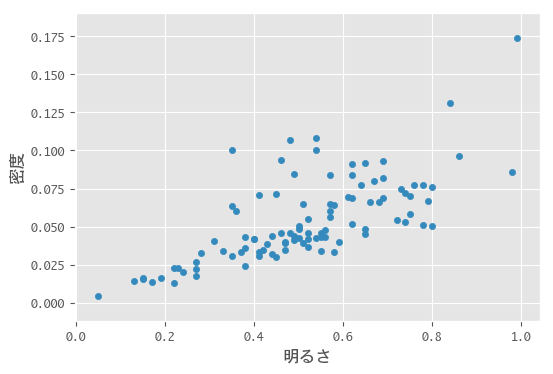

In [223]:
_df = df.copy()
_df['density'] = _df['x']/_df['A']
_df.plot.scatter(x='x', y='density')
plt.xlabel('明るさ')
plt.ylabel('密度')

$\frac{平均個体数\lambda_i}{A_i} = 人口密度$

$\lambda_i = A_i \times 人口密度$

人口密度は正の値なので指数関数と明さ $x_i$ 依存性をくみあわせて次の通りモデル化

$\lambda_i = A_{i}exp(\beta_1 + \beta_2x_i)$

変形して

$\lambda_i = exp(\beta_1 + \beta_2x_i + \log{A_i})$

In [225]:
_df = df.copy()
_df['logA'] = _df['A'].apply(np.log)
_df['intercept'] = 1

In [226]:
poisson_model = sm.GLM(_df[['y']], _df[['x', 'logA', 'intercept']], family=sm.families.Poisson(link=sm.families.links.log))
ret = poisson_model.fit()

In [227]:
ret.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -322.76
Date:                Sun, 18 Feb 2018   Deviance:                       80.795
Time:                        23:39:25   Pearson chi2:                     80.6
No. Iterations:                     4                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x              1.0365      0.078     13.343      0.000       0.884       1.189
logA           0.9525      0.053     18.105      0.000       0.849       1.056
intercept      1.0874      0.134      8.100      0.000       0.824       1.351
==============================================================================
"""

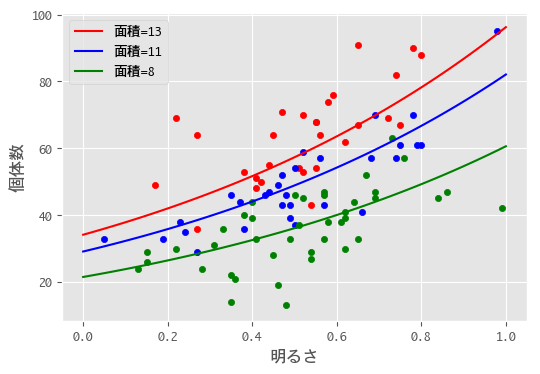

In [249]:
ax = _df.query('12 <= A').plot.scatter(x='x', y='y', color='r')
_df.query('10 <= A < 12').plot.scatter(x='x', y='y', color='b', ax=ax)
_df.query(' A < 10').plot.scatter(x='x', y='y', color='g', ax=ax)
x = np.linspace(0, 1, 100)
ax.plot(x, np.exp(1.0874 + x*1.0365 + 0.9525*np.log(13)), color='r', label='面積=13')
ax.plot(x, np.exp(1.0874 + x*1.0365 + 0.9525*np.log(11)), color='b', label='面積=11')
ax.plot(x, np.exp(1.0874 + x*1.0365 + 0.9525*np.log(8)), color='g', label='面積=8')
plt.ylabel('個体数')
plt.xlabel('明るさ')
plt.legend(loc='best')

### もしかして広告配信におけるCPAなら

$新ロジック適用 i \in \{0, 1\}$

$\displaystyle\frac{\rm{Cost_i}}{\rm{\#Conversion_i}} = \rm{CPA_i}$

$\rm{Cost_i} = \rm{\#Conversion_i} \times \rm{CPA_i}$

CPAは正の連続値により指数関数とロジック $x_i$ 依存性をくみあわせて次の通りモデル化

$\rm{Cost_i} = \rm{\#Conversion_i} \times exp(\beta_1 + \beta_2x_i)$

変形して

$\rm{Cost_i} =  exp(\beta_1 + \beta_2x_i + \log{\rm{\#Conversion_i}})$

とする事でコストはCV数に比例する仮定を反映させつつ新ロジックの効果を推定できる???


##  6.8 ガンマ分布のGLM

In [167]:
df = pd.read_csv('./d.RData.csv')[['x', 'y']]
df.head()

,x,y
0,0.001000,0.000887
1,0.017306,0.023465
2,0.033612,0.069876
3,0.049918,0.034340
4,0.066224,0.026520


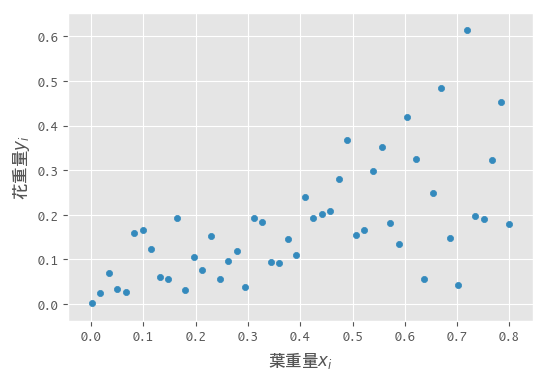

In [204]:
df.plot(x='x', y='y', kind='scatter')
plt.xlabel('葉重量$x_i$')
plt.ylabel('花重量$y_i$')

$\mu_i = Ax_{i}^{b}$ と仮定する、右辺で $A = exp(a)$ とおいてから、全体を指数関数でまとめる  

$\mu_i = exp(a)x_{i}^{b} = exp(a)exp(\log(x_{i}^{b})) = exp(a+b\log x_i)$  

両辺の対数を取ると

$log(\mu_i) = a+b\log x_i$

In [194]:
_df = df[['y']]
_df['logx'] = df['x'].apply(np.log)
_df['intercept'] = 1
gamma_model = sm.GLM(_df[['y']], _df[['logx', 'intercept']], family=sm.families.Gamma(link=sm.families.links.log))
ret = gamma_model.fit()

In [195]:
ret.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   50
Model:                            GLM   Df Residuals:                       48
Model Family:                   Gamma   Df Model:                            1
Link Function:                    log   Scale:                  0.325084320549
Method:                          IRLS   Log-Likelihood:                 58.471
Date:                Tue, 13 Feb 2018   Deviance:                       17.251
Time:                        09:30:48   Pearson chi2:                     15.6
No. Iterations:                    10                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
logx           0.6832      0.068      9.992      0.000       0.549       0.817
intercept     -1.0403      0.119     -8.759      0.000      -1.273      -0.808
==============================================================================
"""

In [201]:
x = np.linspace(0.001, 0.8, 200) # 重量がゼロはありえない
y = np.exp(-1.0403 + 0.6832*np.log(x))

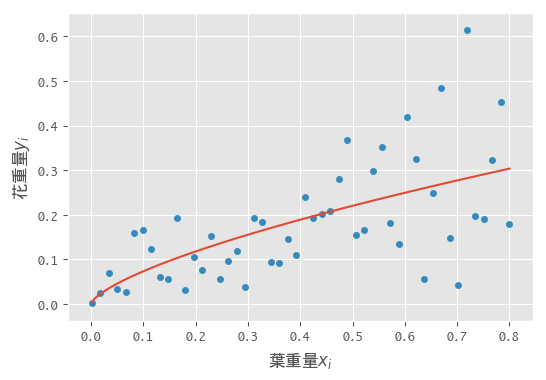

In [205]:
ax = df.plot(x='x', y='y', kind='scatter')
ax.plot(x, y)
plt.xlabel('葉重量$x_i$')
plt.ylabel('花重量$y_i$')